# Imports

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Data Base

In [2]:
%%capture

from djimaging.user.alpha.utils.populate_alpha import load_alpha_config, SCHEMA_PREFIX

load_alpha_config(schema_name=SCHEMA_PREFIX + "soma")

In [3]:
from djimaging.utils.dj_utils import activate_schema
from djimaging.user.alpha.schemas.alpha_somas_schema import *

activate_schema(schema=schema, create_schema=False, create_tables=False)

# Plot

In [4]:
from alphaanalysis import plot as plota

plota.set_rc_params()

In [5]:
from djimaging.user.alpha.tables.morphology import match_utils

In [6]:
palette = plota.get_palette(indicator='calcium')

In [7]:
n_reps_min = 2
q_thresh = 0.5

spot_loc_tab = (WbgSpots * RetinalFieldLocation & dict(condition='control')) & (
            Roi & (ChirpQI & "qidx>0.35" & dict(stim_name='gChirp', condition='control')))
spot_loc_q_tab = spot_loc_tab & f"w_qidx>{q_thresh}" & [f"g_qidx>{q_thresh}",
                                                        f"b_qidx>{q_thresh}"] & f"n_reps>={n_reps_min}"

plot_spot_keys, vd_pos, tn_pos = spot_loc_q_tab.fetch('KEY', 'ventral_dorsal_pos_um', 'temporal_nasal_pos_um')
len(plot_spot_keys)

tmp_keys = (spot_loc_q_tab & "temporal_nasal_pos_um<-0" & "ventral_dorsal_pos_um<1000" & plot_spot_keys).fetch('KEY')
nsl_keys = (spot_loc_q_tab & "temporal_nasal_pos_um>0" & plot_spot_keys).fetch('KEY')

nt_pos_rot, vd_pos_rot = match_utils.rotate_point_around_center(px=-tn_pos, py=vd_pos, ang_deg=22.1)
sort_idx = np.argsort(nt_pos_rot)
plot_spot_keys = np.array(plot_spot_keys)[sort_idx][::-1]

tick_colors = []
for key in plot_spot_keys:
    if key in tmp_keys:
        col = palette['t']
    elif key in nsl_keys:
        col = palette['n']
    else:
        col = 'k'
    tick_colors.append(col)

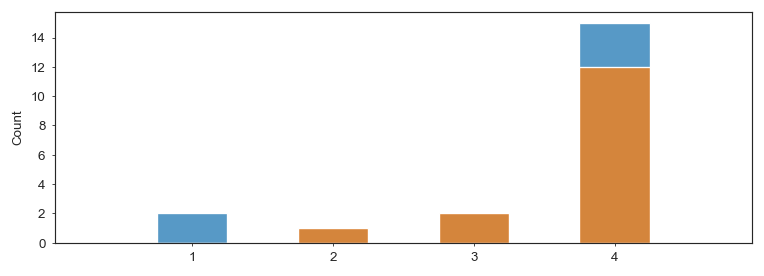

In [8]:
sns.histplot(spot_loc_tab.fetch('n_reps'), bins=np.arange(0, 5, 0.5) + 0.25);
sns.histplot(spot_loc_q_tab.fetch('n_reps'), bins=np.arange(0, 5, 0.5) + 0.25);

In [9]:
spot_sizes = [100, 200, 300, 400, 600, 1000]

In [10]:
t_key = \
(spot_loc_q_tab & "temporal_nasal_pos_um<-500" & "-500<ventral_dorsal_pos_um<500" & "w_spot_surround_index<-0.3").fetch(
    'KEY', order_by='w_qidx')[-2]
n_key = \
(spot_loc_q_tab & "temporal_nasal_pos_um>500" & "-500<ventral_dorsal_pos_um<500" & "w_spot_surround_index>-0.1").fetch(
    'KEY', order_by='w_qidx')[-4]

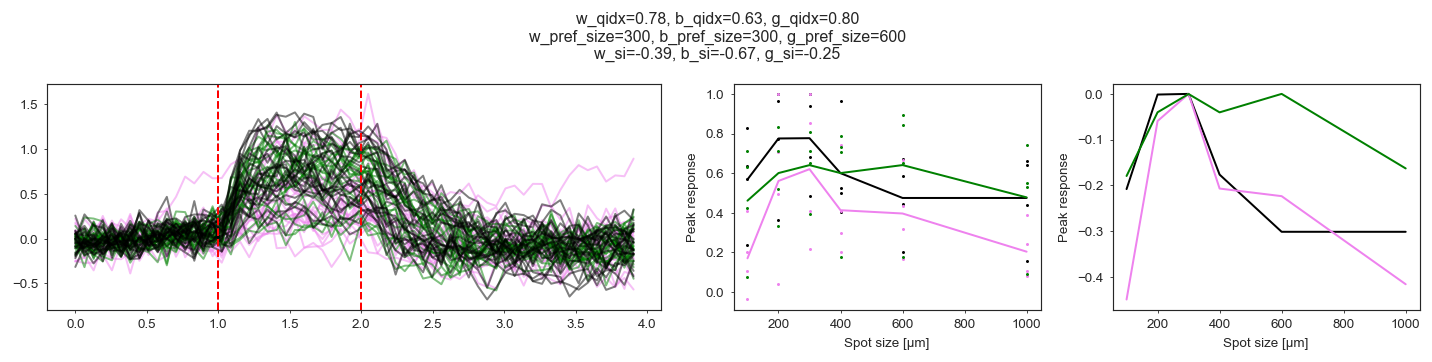

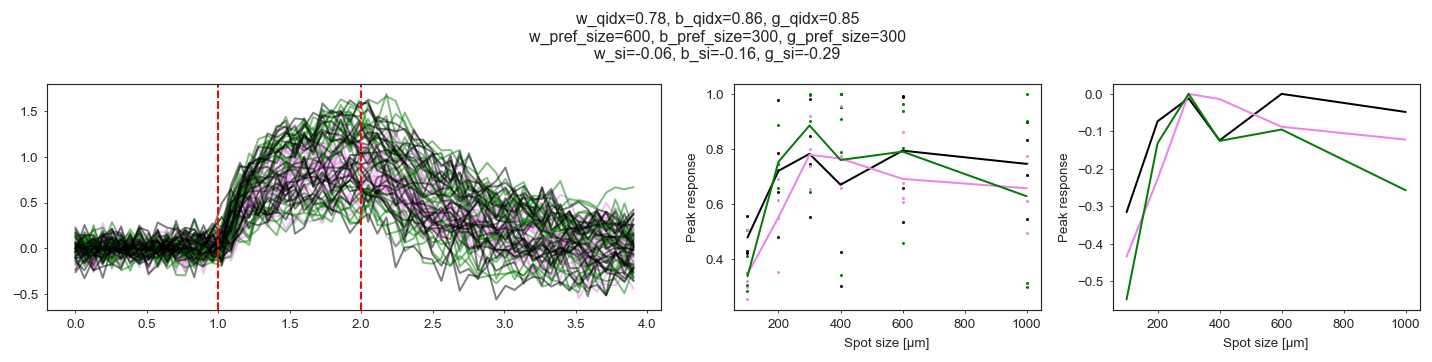

In [11]:
(WbgSpots & t_key).plot1()
(WbgSpots & n_key).plot1()

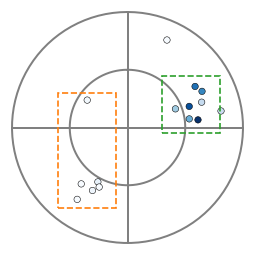

In [12]:
from matplotlib.cm import ScalarMappable


def plot_w_si_on_locs(axs, tab):
    # Lazy normalization of position
    x = -tab.fetch('temporal_nasal_pos_um') / 2000
    y = tab.fetch('ventral_dorsal_pos_um') / 2000

    x, y = match_utils.rotate_point_around_center(px=x, py=y, ang_deg=22.1)
    c = tab.fetch('w_spot_surround_index')

    norm = plt.Normalize(vmin=np.min(c), vmax=0)

    plot_locations(axs, x=x, y=y, c=c, norm=norm, cbar_label='Surround\nindex\n(white)')

    import matplotlib.patches as patches
    rect = patches.Rectangle((0.3, -0.05), 0.5, 0.5, linewidth=1, edgecolor=palette['t'], facecolor='none',
                             linestyle='--', zorder=1000)
    axs[0].add_patch(rect)

    rect = patches.Rectangle((-0.6, -0.7), 0.5, 1., linewidth=1, edgecolor=palette['n'], facecolor='none',
                             linestyle='--', zorder=1000)
    axs[0].add_patch(rect)


def plot_locations(axs, x, y, c, norm, cbar_label=''):
    ax = axs[0]
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plota.plot_location_grid(ax, text=False, change_axis=False)
    sns.scatterplot(ax=ax, x=x, y=y, hue=c, palette='Blues_r', hue_norm=norm, edgecolor='k', legend=False, zorder=100,
                    s=15)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    if len(axs) > 1:
        ax = axs[1]
        cbar = fig.colorbar(ScalarMappable(cmap='Blues_r', norm=norm), cax=ax, ticks=[-0.5, 0], orientation='vertical')
        cbar.set_label(cbar_label, rotation=270, labelpad=25)


plot_w_si_on_locs(axs=[plt.subplot(111)], tab=spot_loc_q_tab)

/tmp/ipykernel_11676/3618937071.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=[si_nsl, si_tmp], ax=ax, s=2, clip_on=False, alpha=0.8, color='k', marker='o', edgecolor='k',


0.0023093703339801762


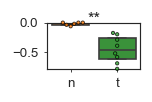

In [13]:
def plot_test(ax):
    si_tmp, tn_pos_tmp, vd_pos_tmp = (spot_loc_q_tab & tmp_keys).fetch('w_spot_surround_index', 'temporal_nasal_pos_um',
                                                                       'ventral_dorsal_pos_um')
    si_nsl, tn_pos_nsl, vd_pos_nsl = (spot_loc_q_tab & nsl_keys).fetch('w_spot_surround_index', 'temporal_nasal_pos_um',
                                                                       'ventral_dorsal_pos_um')

    sns.swarmplot(data=[si_nsl, si_tmp], ax=ax, s=2, clip_on=False, alpha=0.8, color='k', marker='o', edgecolor='k',
                  palette=[palette['n'], palette['t']], linewidth=0.5)
    sns.boxplot(data=[si_nsl, si_tmp], ax=ax, whis=False, fliersize=0, zorder=-10, palette=[palette['n'], palette['t']])

    ax.set_xticks([0, 1], ['n', 't'])
    ax.set_ylim(np.min(np.concatenate([si_nsl, si_tmp])), 0)

    from scipy.stats import mannwhitneyu

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(si_nsl, si_tmp, alternative='two-sided')

    print(p_value)

    if p_value < 0.001:
        ax.set_title('***', y=1.02, va='top')
    elif p_value < 0.01:
        ax.set_title('**', y=1.02, va='top')
    elif p_value < 0.05:
        ax.set_title('*', y=1.02, va='top')


plot_test(ax=plt.subplots(1, 1, figsize=(1, 0.5))[1])

In [14]:
spot_stim_t = np.array([-1, 0 - 1e-6, 0, 1, 1 + 1e-6, 3])
spot_stim = np.zeros_like(spot_stim_t)
spot_stim[(spot_stim_t >= 0) & (spot_stim_t <= 1)] = 0.1


def plot_spot_response(axs, key, legend=False):
    data_dict, n_reps = (WbgSpots & key).fetch1('data_dict', 'n_reps')
    fs = (Presentation.ScanInfo & key).fetch1('scan_frequency')
    snippets = data_dict['snippets']
    tuning_curves = data_dict['tuning_curves']

    ax = axs[0]
    ax.plot(spot_stim_t, spot_stim + 1.7, c='k', clip_on=False, zorder=1000)

    idx_max = int(4 * fs)
    lss = ['-', '--']
    for col in ['W', 'B', 'G']:
        for i, size in enumerate([300, 1000]):
            snips = snippets[f'{col}{"0" if size < 1000 else ""}{size}']
            avg = np.nanmean(snips, axis=1)
            avg_std = np.nanstd(snips, axis=1, ddof=1) / np.sqrt(n_reps)
            avg_t = np.arange(avg.size) / fs - 1

            if col == 'W':
                c = 'k'
                label = str(size)
            elif col == 'B':
                c = 'violet'
                label = '_'
            else:
                c = 'green'
                label = '_'
            z = np.random.randint(0, 100)
            ax.plot(avg_t[:idx_max], avg[:idx_max], color=c, alpha=1, lw=1, zorder=z, ls=lss[i], label=label)
            #ax.fill_between(avg_t[:idx_max], avg[:idx_max] - avg_std[:idx_max], avg[:idx_max] + avg_std[:idx_max], color=c, alpha=0.2, zorder=z-1, lw=0)

    if legend:
        ax.legend(loc='upper right', borderaxespad=0.5,
                  handlelength=1.2, handletextpad=0.1, frameon=False,
                  columnspacing=1)

    ax.axvline(0, c='dimgray', ls='--')
    ax.axvline(1, c='dimgray', ls='--')
    #ax.fill_between([WbgSpots()._t_peak_a -1, WbgSpots()._t_peak_b -1], [-0.5, -0.5], [1.5, 1.5], color='lightgray')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Response\n[a.u.]')
    ax.set_ylim(None, np.max(spot_stim + 1.7))

    ax = axs[1]
    ax.plot(spot_sizes, tuning_curves['W'], marker='s', c='k', clip_on=False)
    ax.plot(spot_sizes, tuning_curves['B'], marker='o', c='violet', clip_on=False, alpha=0.8)
    ax.plot(spot_sizes, tuning_curves['G'], marker='v', c='green', clip_on=False, alpha=0.8)
    ax.set_xticks(spot_sizes, spot_sizes, rotation=90)
    ax.set_xlabel('Spot size [µm]')
    ax.set_ylabel('Mean\nresponse\n[a.u.]')
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])

/tmp/ipykernel_11676/3618937071.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=[si_nsl, si_tmp], ax=ax, s=2, clip_on=False, alpha=0.8, color='k', marker='o', edgecolor='k',


0.0023093703339801762


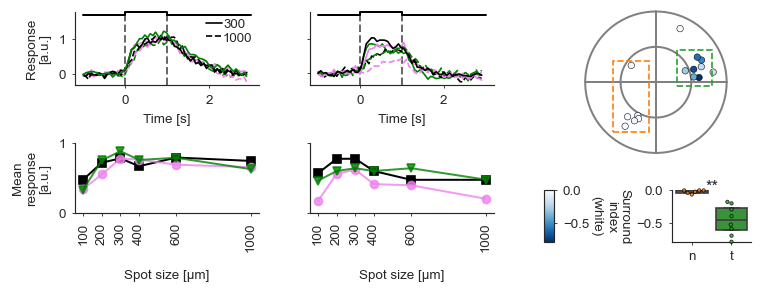

In [15]:
cb_h = 2

fig, axs = plt.subplot_mosaic([
    ['A1', 'B1', 'locs', 'locs', 'locs'],
    ['A1', 'B1', 'locs', 'locs', 'locs'],
    ['A2', 'B2', 'locs', 'locs', 'locs'],
    ['A2', 'B2', 'locs_cb', '.', 'test'],
], figsize=(6.7, 2.4), width_ratios=(1, 1, 0.05, 0.4, 0.3), height_ratios=(cb_h, 2, 1, cb_h))

sns.despine()

plot_spot_response([axs['A1'], axs['A2']], n_key, legend=True)
plot_spot_response([axs['B1'], axs['B2']], t_key)

for ax in [axs['B1'], axs['B2']]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

plot_w_si_on_locs([axs['locs'], axs['locs_cb']], spot_loc_q_tab)

plt.tight_layout(w_pad=-2, h_pad=1)

plota.change_box(axs=axs['locs'], dx=0.02, dy=0.02)
plota.move_box(axs=axs['locs'], dx=-0.02, dy=-0.02)

plota.change_box(axs=axs['locs_cb'], dy=0.15)
plota.move_box(axs=axs['locs_cb'], dy=-0.1)

plota.change_box(axs['test'], dy=0.15, dx=0.03)
plota.move_box(axs['test'], dx=-0.07, dy=-0.1)

fig.align_labels()

plot_test(axs['test'])

plt.savefig('figures/soma_spot_responses.pdf')

### Tuning curves

In [16]:
all_tuning_curves = {'W': [], 'B': [], 'G': []}
all_surround_indexes = {'W': [], 'B': [], 'G': []}
all_chirps = []

for key in plot_spot_keys:
    data_dict = (WbgSpots & key).fetch1('data_dict')
    tuning_curves = data_dict['tuning_curves']
    for col in ['W', 'B', 'G']:
        all_tuning_curves[col].append(tuning_curves[col])
        all_surround_indexes[col].append((WbgSpots & key).fetch1(f'{col.lower()}_spot_surround_index'))
        all_chirps.append((Averages & dict(stim_name='gChirp', condition='control') & (Roi & key)).fetch1('average'))

for col in ['W', 'B', 'G']:
    all_tuning_curves[col] = np.vstack(all_tuning_curves[col])

In [17]:
from copy import deepcopy

all_tuning_curves_norm = deepcopy(all_tuning_curves)
for i in range(len(plot_spot_keys)):
    i_max = 0
    for col in ['W', 'B', 'G']:
        i_max = np.maximum(i_max, all_tuning_curves_norm[col].max())
    for col in ['W', 'B', 'G']:
        all_tuning_curves_norm[col] /= i_max

In [18]:
from djimaging.utils.filter_utils import downsample_trace
from djimaging.utils.math_utils import truncated_vstack

fs = Averages._f_resample

chirp_time = np.arange(all_chirps[0].size) / fs

# Downsample for plotting
ds = 50
ds_fs = fs / ds
ds_chirps = [downsample_trace(chirp_time, chirp, fdownsample=ds)[1] for chirp in all_chirps]
ds_chirps = truncated_vstack(ds_chirps)

norm_chirps = (ds_chirps.T - np.mean(ds_chirps[:, :int(2 * ds_fs)], axis=1)).T
norm_chirps = (norm_chirps.T / np.max(np.abs(norm_chirps), axis=1)).T

In [19]:
tag_cmap = sns.color_palette("dark", 17)

In [20]:
def plot_loc_tags(ax):
    x = np.array([-(spot_loc_q_tab & key).fetch1('temporal_nasal_pos_um') / 2000 for key in plot_spot_keys])
    y = np.array([(spot_loc_q_tab & key).fetch1('ventral_dorsal_pos_um') / 2000 for key in plot_spot_keys])
    x, y = match_utils.rotate_point_around_center(px=x, py=y, ang_deg=22.1)
    c = [1] * x.size

    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plota.plot_location_grid(ax, text=False, change_axis=False)

    for i, (xi, yi) in enumerate(zip(x, y)):
        #c = tag_cmap[x.size-i]
        c = tick_colors[i]
        ax.plot(xi, yi, '.', c=c, ms=8)
        ax.text(xi, yi, str(x.size - i), ha='center', va='center', zorder=200, alpha=1, c='k', fontsize=4)

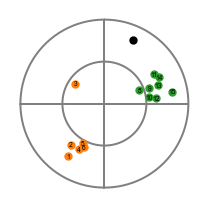

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_loc_tags(ax)

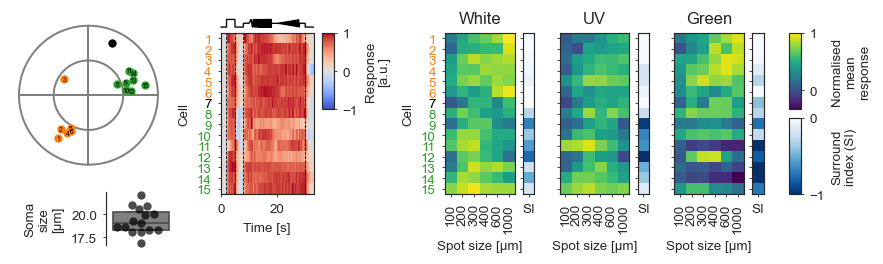

In [22]:
col2title = {"W": 'White', 'B': 'UV', 'G': 'Green'}
col_order = ['W', 'B', 'G']

w_scale = 6
c_scale = 8
l_scale = 10
space = 6

fig, axs = plt.subplot_mosaic([
    ['.', '.', 'ChirpSt', '.', '.', '.', '.', '.', '.', '.', '.', '.', ],
    ['L', '.', 'Chirp', 'CCB', '.', 'W1', 'W2', 'B1', 'B2', 'G1', 'G2', 'CB1'],
    ['L', '.', 'Chirp', '.', '.', 'W1', 'W2', 'B1', 'B2', 'G1', 'G2', 'CB2'],
],
    figsize=(7, 2.2), width_ratios=(l_scale, 1, c_scale, 1, space, w_scale, 1, w_scale, 1, w_scale, 1, 1),
    height_ratios=(1, 10, 10))

axs['W1'].set_ylabel('Cell')
for i, (col, col_tuning_curves) in enumerate(all_tuning_curves_norm.items()):
    ax = axs[col + str(1)]
    ax.set_title(col2title[col_order[i]], loc='center')
    im_norm = ax.imshow(col_tuning_curves, aspect='auto', interpolation='none', cmap='viridis',
                        vmin=np.stack(list(all_tuning_curves_norm.values())).min(), vmax=+1,
                        extent=(-0.5, len(spot_sizes) - 0.5, 0.5, len(plot_spot_keys) + 0.5), origin='lower')
    ax.set_xticks(np.arange(len(spot_sizes)), spot_sizes, rotation=90)
    ax.set_xlabel('Spot size [µm]')
    ax.set_yticks(np.arange(1, len(plot_spot_keys) + 1), [''] * (len(plot_spot_keys)))
    ax.set_ylim(0.5, len(plot_spot_keys) + 0.5)

    ax = axs[col + str(2)]
    im_si = ax.imshow(np.array(all_surround_indexes[col])[:, np.newaxis], aspect='auto', cmap='Blues_r',
                      vmin=-1, vmax=0, extent=(-0.5, +0.5, 0.5, len(plot_spot_keys) + 0.5), origin='lower')
    ax.set_xticks([0], ['SI'])
    ax.set_yticks(np.arange(1, len(plot_spot_keys) + 1), [''] * (len(plot_spot_keys)))
    ax.set_ylim(0.5, len(plot_spot_keys) + 0.5)

ax = axs['W1']
ax.set_yticks(np.arange(1, len(plot_spot_keys) + 1)[::-1], np.arange(1, len(plot_spot_keys) + 1))
ax.set_ylabel('Cell')
for ticklabel, tick_color in zip(ax.get_yticklabels(), tick_colors[::-1]):
    ticklabel.set_color(tick_color)

ax = axs['Chirp']
im_chirp = ax.imshow(norm_chirps, aspect='auto', interpolation='none', vmax=+1, vmin=-1,
                     cmap='coolwarm', extent=(0, chirp_time.max(), 0.5, len(plot_spot_keys) + 0.5), zorder=-10,
                     origin='lower')
plota.lines(ax=ax, ts=[2, 5, 8, 30], c='k')
#ax.axis('off')
ax.set_yticks(np.arange(1, len(plot_spot_keys) + 1)[::-1], np.arange(1, len(plot_spot_keys) + 1))
ax.set_ylabel('Cell')
for ticklabel, tick_color in zip(ax.get_yticklabels(), tick_colors[::-1]):
    ticklabel.set_color(tick_color)
plt.colorbar(im_chirp, ax=ax, cax=axs['CCB'], label='Response\n[a.u.]')
ax.set_ylim(0.5, len(plot_spot_keys) + 0.5)
ax.set_xlabel('Time [s]')

ax = axs['ChirpSt']
plota.plot_chirp(ax=ax, c='k', tmax=chirp_time.max(), yscale=1, clip_on=False, lw=0.8)
ax.set_xlim(0, chirp_time.max())
ax.set_ylim(0, 1)
ax.axis('off')

cbar1 = fig.colorbar(im_norm, cax=axs['CB1'], ticks=[0, 1], label='Normalised\nmean\nresponse')
cbar2 = fig.colorbar(im_si, cax=axs['CB2'], ticks=[-1, 0], label='Surround\nindex (SI)')

ax = axs['L']
plot_loc_tags(ax)

fig.align_ylabels()
plt.tight_layout(w_pad=-3, h_pad=-1)

for col in ['W', 'B', 'G']:
    plota.move_box(axs[col + '2'], dx=-0.01)
plota.move_box(axs['ChirpSt'], dy=-0.01)
plota.move_box(axs['CCB'], dx=-0.01)

bbox = axs['L'].get_position()
bbox_w = bbox.x1 - bbox.x0
ax = fig.add_axes([bbox.x0 + 0.4 * bbox_w, 0.08, 0.6 * bbox_w, 0.2])
roi_sizes = (SizeRoi & plot_spot_keys).fetch('roi_dia_um')
sns.swarmplot(ax=ax, y=roi_sizes, clip_on=False, color='k', alpha=0.7)
sns.boxplot(ax=ax, y=roi_sizes, whis=False, fliersize=0, zorder=-10, color='gray')
ax.set_ylabel('Soma\nsize\n[µm]')
ax.set_xticks([])

ax.spines['right'].set_visible(0)
ax.spines['top'].set_visible(0)
ax.spines['bottom'].set_visible(0)

plota.change_box(axs['L'], dx=0.14, dy=0.14)
plota.move_box(axs['L'], dx=-0.105)

plt.savefig('figures/soma_spot_responses_heatmaps.pdf', bbox_inches='tight')